# Inversion geoelektrischer Profilmessungen mit `pyGIMLi` 

Das Ziel der Inversion besteht in der Rekonstruktion der räumlichen Verteilung der spezifischen Widerstände im Untergrund.
Grundlage bilden die gemessenen Daten, in der Regel sind das Ohmsche Widerstände $R(L)$ in $\Omega$ oder scheinbare spezifische Widerstände $\rho_s(L)$ in $\Omega\cdot m$.
Sämtliche Messwerte sind abhängig vom Ort und der geoelektrischen Elektrodenkonfiguration (hier durch $L$ gekennzeichnet).

### Installation

Bei `pyGIMLi` handelt es sich um eine Python-Bibliothek.
Wir setzen voraus, dass eine Python-Umgebung bereits installiert ist.
Am einfachsten funktioniert [*anaconda*](https://www.anaconda.com/products/individual).

Zunächst muss `pyGIMLi` installiert werden, damit unter Python darauf zugegriffen werden kann.
Das geschieht mit `conda`:
```shell
conda install -c gimli -c conda-forge pygimli=1.2.2
```

### Vorbereitung

Wir importieren die beiden Bibliotheken `pygimli` und `numpy`.

In [1]:
%matplotlib inline

In [1]:
import pygimli as pg
import numpy as np
from pygimli.physics.ert import ERTManager
from pygimli.physics import ert

# Das Datenformat

`pyGIMLi` erwartet die geoelektrischen Messwerte in einem speziellen Dateiformat, dem *Unified Data Format* [(Beschreibung auf der Projektseite von BERT)](https://gitlab.com/resistivity-net/bert#the-unified-data-format).
Es handelt sich um ASCII-Dateien, welche mit allen gängigen Texteditoren editiert werden können.

Eine solche Messwertdatei enthält folgende Abschnitte:
- Anzahl der Elektroden sowie Koordinaten (Lage und Höhe) der Elektroden mit impliziter Nummerierung
- Anzahl der Messwerte sowie die sich jeweils aus der Kombination von zwei bis vier Elektroden ergebenden Daten

Das Beispiel zeigt einen kleinen Datensatz mit 6 Elektroden und 6 Einzelmessungen in der Konfiguration *Dipol-Dipol* (erkennbar an der Reihenfolge *a b m n* der Elektroden und Sonden).
Die 5. Spalte des Datenblocks enthält den scheinbaren spezifischen Widerstand (`rhoa`) in $\Omega\cdot m$.

```text
6# Number of electrodes
# x z position for each electrode
0     0
1     0
2     0 # loose ground
3     0
4     0
5     0
6# Number of data
# a b m n rhoa
1   2   3   4  231.2
2   3   4   5  256.7
3   4   5   6  312.8 
1   2   4   5  12.1 # possibly an outlier
2   3   5   6  199.7
1   2   5   6  246.2
```

## Inversion eines echten Datensatzes
Wir verwenden für dieses Beispiel Daten einer Messung auf dem Campusgelände der TU Bergakademie Freiberg. Der "Erzgang" ist aus dem Grundlagenpraktikum bereits bekannt (Versuch *Elektromagnetische Kartierung*).

Die Profilmessung wurde mit den Konfigurationen *Wenner*, *Dipol-Dipol* und *Pol-Dipol* mit 21 Elektroden durchgeführt.

Der Dipol-Dipol-Datensatz besteht aus 93, der Pol-Dipol-Datensatz aus 99 und der Wenner-Datensatz aus 63 Einzelmessungen.

Die Python-Objekte `dipoldipol`, `wenner` und `poldipol` enthalten sämtliche gemessenen Daten:

In [2]:
# wenner = pg.load("energy_3_all_2023_01_20.mea")
# wenner = pg.load("farn_we_01_1.mea");
# sb = pg.load("farn_sb_01.mea");
# dd = pg.load("Erzgang/erz_17_10_dd_new.mea");
wenner = pg.load("Erzgang/erz_18_10_1_dd_new.mea")
print(wenner)
# print(sb)

Data: Sensors: 42 data: 284, nonzero entries: ['a', 'b', 'm', 'n', 'rhoa', 'valid']


In der `pyGIMLi`-Methode `ERTManager()` sind alle Funktionen zur Inversion von Geoelektrikdaten (engl. *Electrical Resistivity Tomography*, ERT) implementiert.

Die Objekte `ertwenner` bzw. `ertpoldipol` werden u.a. die Modellantwort und die Modellparameter aufnehmen.

In [4]:
ertwenner = ERTManager()
# wenner.add(sb)

Da unsere Datensätze keine Messfehler enthalten, schätzen wir plausible absolute und relative Datenfehler ab.
Absolute Fehler sind in in $\Omega\cdot m$ angegeben.

In [14]:
wenner['err'] = ertwenner.estimateError(wenner, absoluteError=0.1, relativeError=0.01)

Die folgende Abbildung zeigt eine *Pseudosektion* der **scheinbaren spezifischen Widerstände** $\rho_s$.
Die Trapezform kommt durch die willkürliche Wahl des horizontalen Bezugspunktes im Profilverlauf für die Wenner- bzw. Pol-Dipol-Anordnung zustande.
Die Ordinaten in den beiden folgenden Abbildungen stellen den Elektrodenabstand bei Wenner bzw. die Separation zwischen Strompol und Spannungsdipol bei Pol-Dipol dar.
**Es handelt sich nicht um eine Tiefenachse!**

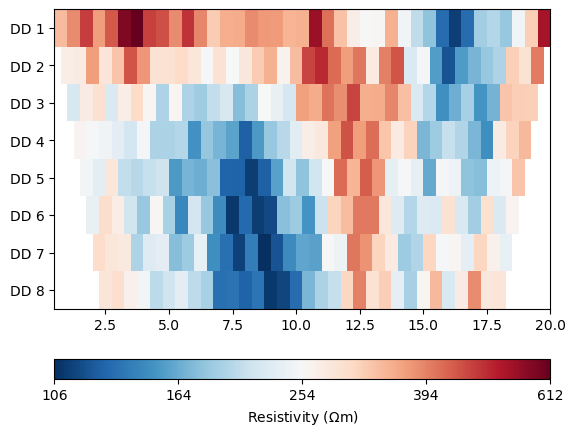

In [15]:
ertwenner.showData(wenner, cMap="RdBu_r");

### Dateninversion

Die Methode `ert.invert` führt die Inversion der Daten (`data`) für einen festgelegten Regularisierungsparameter $\lambda$ (`lam=10`) sowie eine maximale Modelltiefe von `paraDepth=10` Metern und einer maximalen Dreiecksgröße der Finiten Elemente von `paraMaxCellSize=1` $m^2$ durch.

Die Resultate der Inversionsrechnung -- die Verteilung der spezifischen Widerstände im Untergrund und die Modellantwort -- werden im Objekt `mod` gespeichert.

Dem Parameter `lam` wird der Wert des gewählten *Regularisierungsparameters* $\lambda$ zugeordnet.

Bei zu niedrigen Werten von $\lambda$ äußert sich eine ggf. vorliegende Singularität des Kleinste-Quadrate-Problems durch stark schwankende Werte in der Widerstandsverteilung im Untergrund.
Im umgekehrten Fall wird bei zu großem $\lambda$ die Widerstandsverteilung sehr glatt.

Hier können wir ausprobieren, welchen Einfluss der Regularisierungsparameter auf die Lösung unseres Problems hat.

In [16]:
lam = 30

In [17]:
wenner['k'] = ert.geometricFactors(wenner)

In [18]:
modwenner = ertwenner.invert(wenner, lam=lam, paraMaxCellSize=0.2, paraDepth=8, verbose=False);

08/12/23 - 14:06:24 - pyGIMLi - INFO - Use median(data values)=247.39
08/12/23 - 14:06:24 - pyGIMLi - INFO - Created startmodel from forward operator: 1790, min/max=247.390000/247.390000


Die folgenden Abbildungen veranschaulichen den Zusammenhang zwischen den Modellparametern ($\rho(\mathbf r)$) sowie den gemessenen scheinbaren spezifischen Widerständen (`Data`) und der Modellantwort (`Response`).

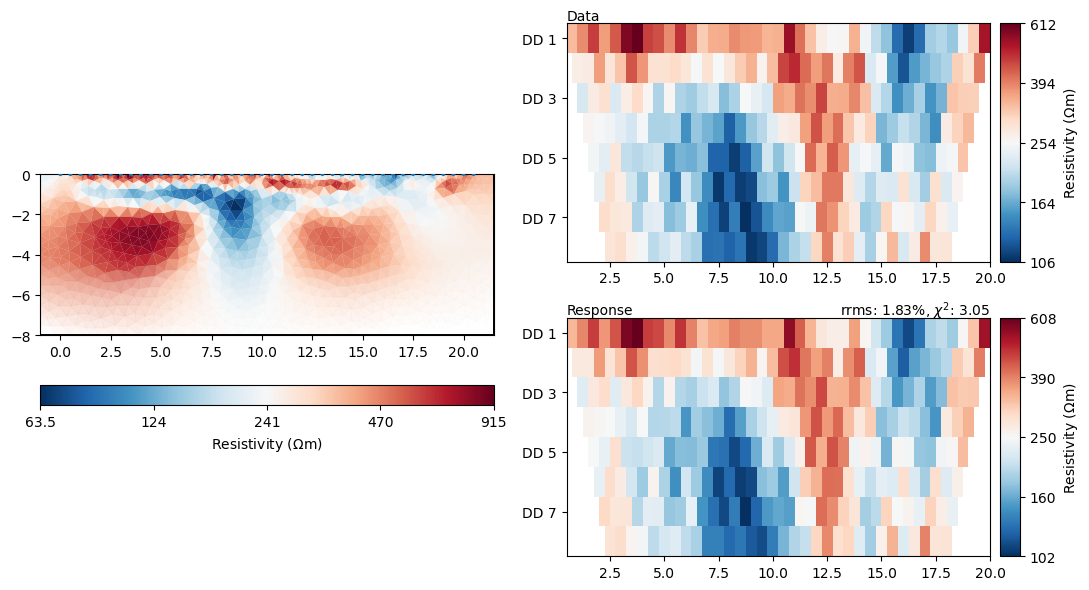

In [19]:
ertwenner.showResultAndFit(cMap="RdBu_r");

Das Modell kann hier etwas genauer betrachtet werden.
Es fällt auf, dass im Bereich der Profilmeter 10-15 eine steil einfallende Zone mit geringerem spezifischen Widerstand auftritt.
Das Umgebungsgestein ist Freiberger Gneis.
Bei der Störung handelt es sich um eine tonführende Verwitterungszone.

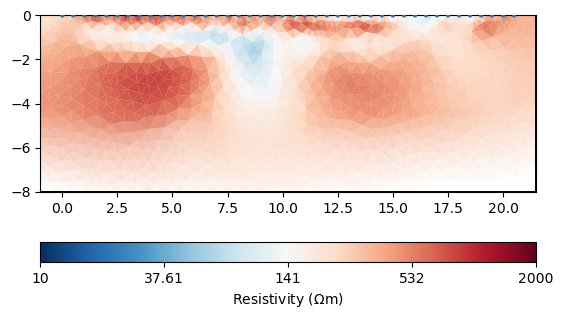

In [20]:
ertwenner.showModel(modwenner, cMap="RdBu_r", cMin=10, cMax=2000);

Von Interesse ist die Anpassungsgüte, die wir als *misfit* bezeichnen.
Dabei wird der relative Fehler zwischen Daten und Modellantwort gebildet.
Aufschlussreich ist eine graphische Darstellung dieses Fehlers:

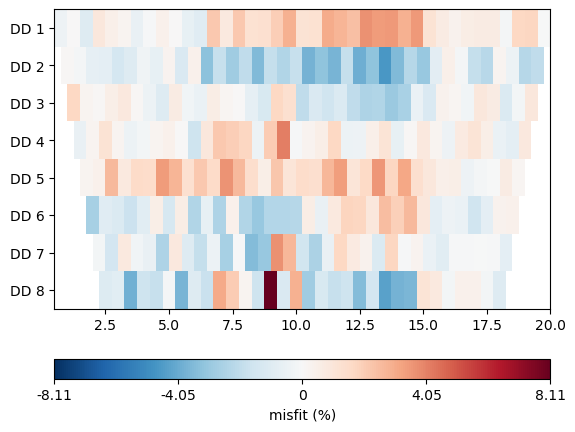

In [21]:
misfitwe = ertwenner.inv.response / wenner['rhoa'] * 100 - 100
me = np.max(np.abs(misfitwe))
pg.show(wenner, misfitwe, cMap="RdBu_r", cMin=-me, cMax=me, label="misfit (%)");

Der globale Anpassungsfehler wird mit der $\chi^2$-Statistik beschrieben und beträgt für Wenner

In [22]:
ertwenner.inv.chi2()

3.054430971764836

## Diskussion

Wir haben gesehen, dass das Inversionsergebnis durch die Wahl verschiedener Parameter beeinflusst werden kann. Vor allem die Datenanpassung und Modelleigenschaften sind betroffen.

- Welcher Parameter steuert die Rauhigkeit des Modells?
- Welche Konfiguration löst die Störungszone besser auf?